### Paper : https://arxiv.org/abs/1908.07442
### Code : https://github.com/google-research/google-research/tree/master/tabnet
### Doc : https://dreamquark-ai.github.io/tabnet/

[출처] : https://wsshin.tistory.com/5, https://slowsteadystat.tistory.com/23

# Data Load

In [1]:
import pandas as pd

# Dataset : https://www.kaggle.com/datasets/wenruliu/adult-income-dataset
df_raw = pd.read_csv('../data/classification/adult.csv')

df_raw.head(5)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,y
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,0


# Check Missing Value

In [2]:
def check_missing(df, fillna=None):
    # !pip install missingno
    import missingno as msno
    
    print(f"\n# of observations : {df.shape[0]}")
    print(f"# of features : {df.shape[1]}\n")
    
    print("Ratio of missing values in a column (%)")
    print(round( df.isnull().sum() / df.shape[0] * 100, 2))
    
    %matplotlib inline
    msno.matrix(df)
    
    for idx, i in enumerate(df.isnull().sum()):
        if i > 0:
            if df.iloc[:,idx].dtype == 'object':
                print(f"The {idx}-th column\n")
                print(df.iloc[:,idx].value_counts(dropna=False))
            else:
                print(f"The {idx}-th column is not object type.")
            print("="*50)
    


# of observations : 48842
# of features : 15

Ratio of missing values in a column (%)
x1     0.00
x2     5.73
x3     0.00
x4     0.00
x5     0.00
x6     0.00
x7     5.75
x8     0.00
x9     0.00
x10    0.00
x11    0.00
x12    0.00
x13    0.00
x14    1.75
y      0.00
dtype: float64
The 1-th column

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
NaN                  2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: x2, dtype: int64
The 6-th column

Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
NaN                  2809
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: x7, dtype: int64
The 13-th colu

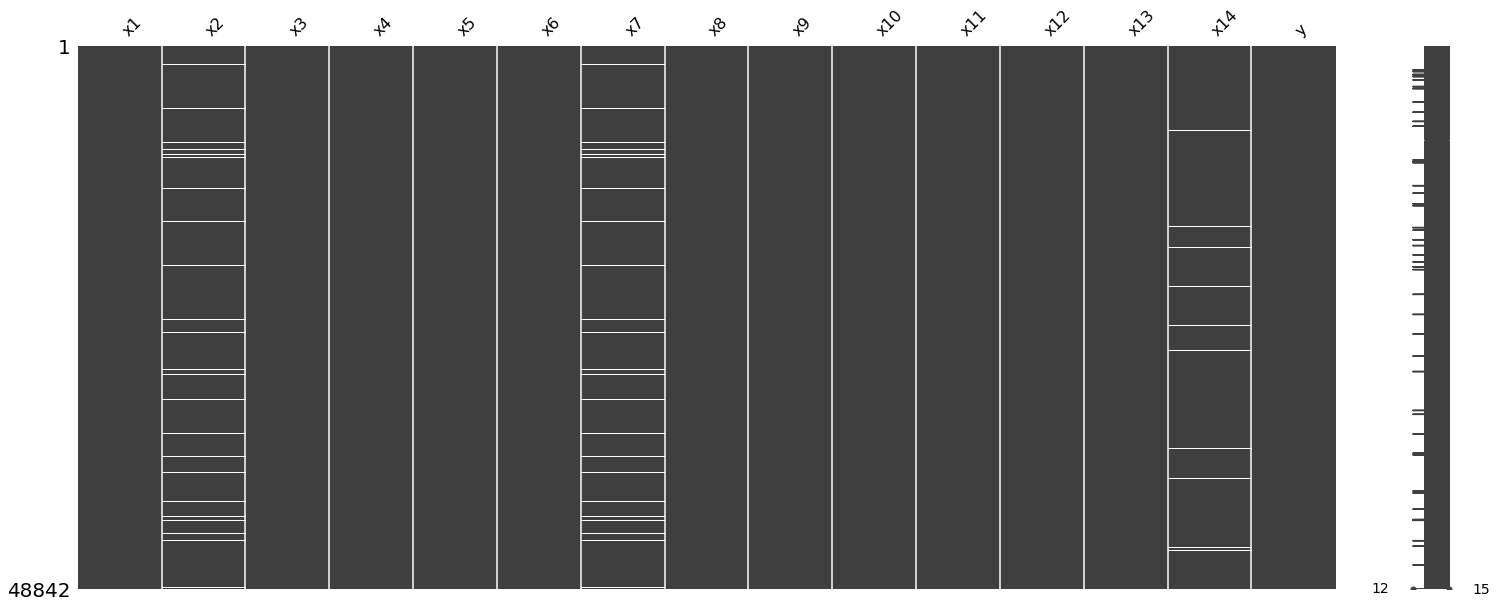

In [3]:
check_missing(df_raw)

In [4]:
df_modified = df_raw.fillna(value='NaN')

# Label Encoding

In [5]:
def label_encoding(df, unused_feat):
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    
    categorical_columns = []
    categorical_dims =  {}
    
    for col in df.columns:
        if df[col].dtype == 'object':
            categorical_columns.append(col)
            categorical_dims[col] = len(df[col].unique())
            
            df[col] = encoder.fit_transform(df[col])
            
    features = [ col for col in df.columns if col not in unused_feat] 
    cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
    cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

    return categorical_columns, categorical_dims, cat_idxs, cat_dims

In [6]:
categorical_columns, categorical_dims, cat_idxs, cat_dims = label_encoding(df_modified, ['Set', 'y'])

# Dataset Splitting

In [7]:
def dataset_split(df, train=.8, valid=.1, test=.1):
    import numpy as np
        
    if "Set" not in df.columns:
        df['Set'] = np.random.choice(['train', 'valid', 'test'], 
                                     p =[.8, .1, .1], 
                                     size=(df.shape[0],))
        
    print(df['Set'].value_counts())

In [8]:
dataset_split(df_modified)

train    39001
test      4979
valid     4862
Name: Set, dtype: int64


In [9]:
def train_test_split(df, target):

    train_indices = df_modified[df_modified.Set=="train"].index
    valid_indices = df_modified[df_modified.Set=="valid"].index
    test_indices = df_modified[df_modified.Set=="test"].index
    
    features = [ col for col in df.columns if col not in ['Set']+[target]]

    X_train = df_modified[features].values[train_indices]
    y_train = df_modified[target].values[train_indices]

    X_valid = df_modified[features].values[valid_indices]
    y_valid = df_modified[target].values[valid_indices]

    X_test = df_modified[features].values[test_indices]
    y_test = df_modified[target].values[test_indices]
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [10]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_test_split(df_modified, 'y')

# Model

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=10,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=1e-2),
                       scheduler_params={"step_size":50,
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax' # "sparsemax", entmax
                      )

In [13]:
max_epochs = 30
save_history = []

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    warm_start=True,
)
save_history.append(clf.history["valid_auc"])

epoch 0  | loss: 0.58102 | train_auc: 0.67533 | valid_auc: 0.6631  |  0:00:02s
epoch 1  | loss: 0.46502 | train_auc: 0.78996 | valid_auc: 0.77955 |  0:00:04s
epoch 2  | loss: 0.44884 | train_auc: 0.84077 | valid_auc: 0.83452 |  0:00:06s
epoch 3  | loss: 0.43547 | train_auc: 0.8728  | valid_auc: 0.87086 |  0:00:08s
epoch 4  | loss: 0.42119 | train_auc: 0.8842  | valid_auc: 0.8806  |  0:00:09s
epoch 5  | loss: 0.41255 | train_auc: 0.89604 | valid_auc: 0.89105 |  0:00:12s
epoch 6  | loss: 0.40487 | train_auc: 0.90193 | valid_auc: 0.90044 |  0:00:16s
epoch 7  | loss: 0.39843 | train_auc: 0.90432 | valid_auc: 0.90264 |  0:00:18s
epoch 8  | loss: 0.39874 | train_auc: 0.90404 | valid_auc: 0.90253 |  0:00:20s
epoch 9  | loss: 0.39195 | train_auc: 0.90558 | valid_auc: 0.90253 |  0:00:22s
epoch 10 | loss: 0.38955 | train_auc: 0.90615 | valid_auc: 0.90254 |  0:00:23s
epoch 11 | loss: 0.38178 | train_auc: 0.90816 | valid_auc: 0.90313 |  0:00:25s
epoch 12 | loss: 0.38923 | train_auc: 0.91068 | vali

# Result

### History

Text(0.5, 1.0, 'learning rate')

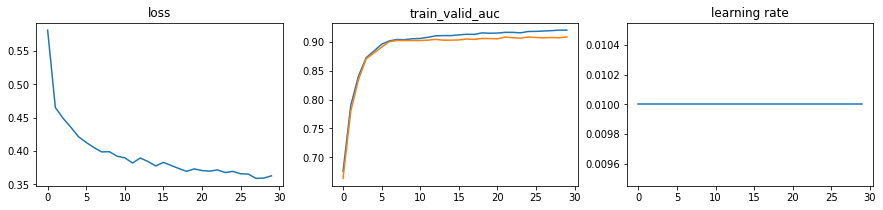

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15,3))

axs[0].plot(clf.history['loss'])
axs[0].set_title(f"loss")

axs[1].plot(clf.history['train_auc'])
axs[1].plot(clf.history['valid_auc'])
axs[1].set_title("train_valid_auc")

axs[2].plot(clf.history['lr'])
axs[2].set_title(f"learning rate")

### Test Score

In [15]:
from sklearn.metrics import roc_auc_score

preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE : {test_auc}")

FINAL TEST SCORE : 0.9141735932643457


### Feature Importance

<AxesSubplot:>

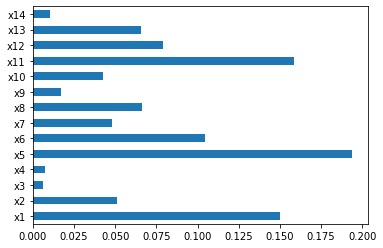

In [16]:
features = [ col for col in df_modified.columns if col not in ['Set', 'y']] 

feat_importances = pd.Series(clf.feature_importances_, index=features)
feat_importances.plot(kind='barh')

In [17]:
explain_matrix, masks = clf.explain(X_test)

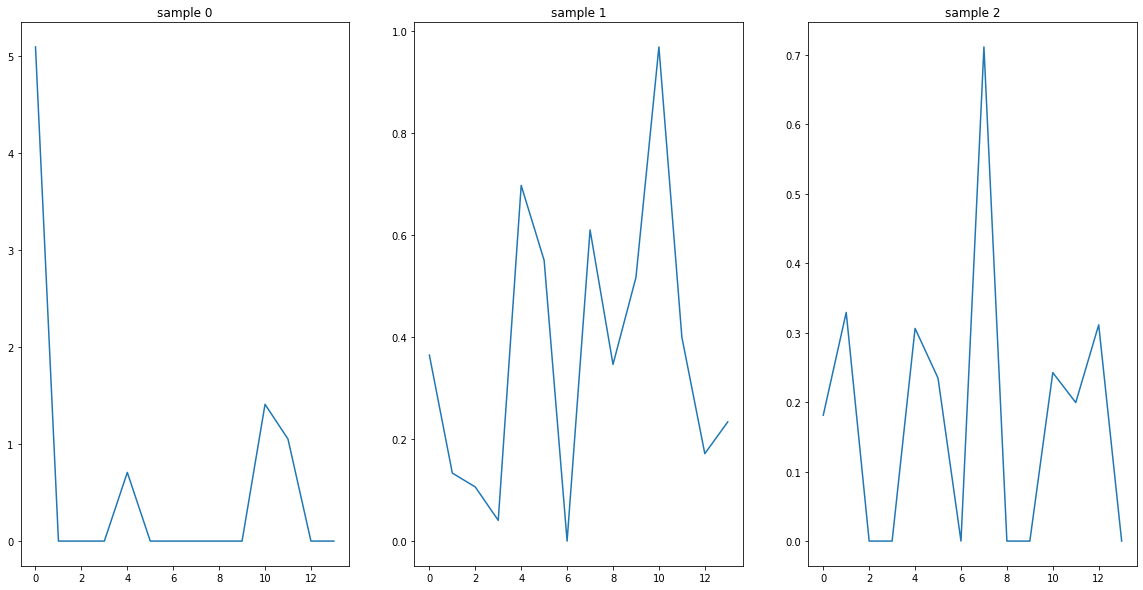

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(20,10))
for i in range(3):
    axs[i].plot(explain_matrix[i])
    axs[i].set_title(f"sample {i}")

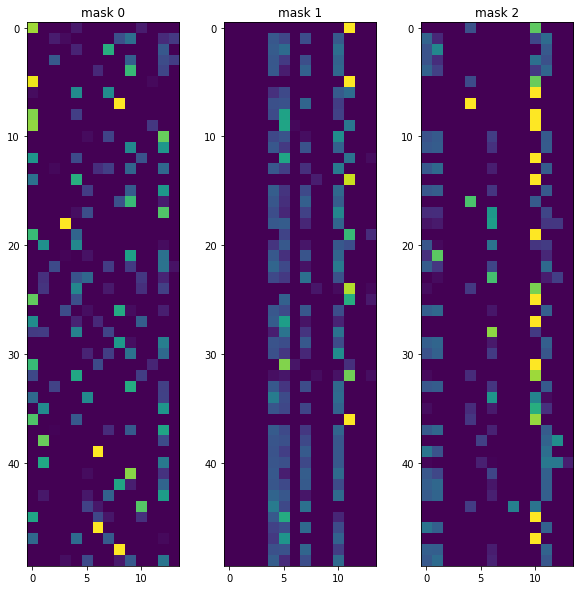

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(10,10))
for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")